In [1]:
import numpy as np
import pandas as pd
import math
import itertools
from sklearn.metrics import DistanceMetric
import networkx as nx
from numpy import inf
from scipy import linalg
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from scipy.spatial.distance import pdist
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score

In [2]:
# Uploading the data
df = pd.read_csv("HeartFailure.csv")
df_cluster = df.iloc[:,1:11]
df_cluster.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex
0,75.0,0,582,0,20,1,265000.00,1.9,130,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0


In [3]:
def data_preprocessing(df):
    '''
    Function processes the data using Principal component analysis(PCA)
    Args:
        df : Dataframe 
    Returns dataframe containing oprincipal component of df
    '''
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)
    df_normalized = normalize(df_scaled)
    df_normalized = pd.DataFrame(df_normalized)
    
    pca = PCA(n_components = 2)
    df_pca = pca.fit_transform(df_normalized)
    df_pca = pd.DataFrame(df_pca)
    df_pca.columns = ['P1', 'P2']
    
    return df_pca

In [4]:
df_pca = data_preprocessing(df_cluster)

In [5]:
def get_graph(df, proximity_measure) :
    '''
    Function to create graph
    Args:
        df: Dataframe
        proximity_measure = Distance measure
        Returns graph of df
    '''
    dist = DistanceMetric.get_metric(proximity_measure)
    matrix_dist = dist.pairwise(df.to_numpy())
    Graph = nx.from_numpy_matrix(matrix_dist)
    
    return Graph

In [6]:
Graph = get_graph(df_cluster,"euclidean")

In [7]:
#equation fro adjacency matrix
def adjacency_matrix_shi_malik(df, sigma, proximity_measure):
    '''
    Function to get adjacency matrix using equation proposed by Shi and Malik algorithm
    Args:
        df: Dataframe
        sigma: 
        proximity_measure = Distance measures
        Returns matrix containing adjacency values
    '''
    dimension = df.shape[0]
    adjacency_matrix = np.zeros([dimension, dimension])
    dist = iter(pdist(df, metric=proximity_measure))

    for i in range(dimension):
        for j in range(i+1, dimension):  
            d = np.exp(-next(dist) ** 2) / (2. * sigma ** 2)
            adjacency_matrix[i,j] = d
            adjacency_matrix[j,i] = d
            
    return adjacency_matrix

In [8]:
adjacency_matrix = adjacency_matrix_shi_malik(df_pca, 0.3, 'euclidean')
adjacency_matrix

array([[0.        , 4.73765499, 4.42668018, ..., 2.22262191, 4.3955364 ,
        4.6994128 ],
       [4.73765499, 0.        , 4.55821815, ..., 3.54834637, 5.0767855 ,
        5.42109133],
       [4.42668018, 4.55821815, 0.        , ..., 1.63249413, 5.3711021 ,
        5.09157925],
       ...,
       [2.22262191, 3.54834637, 1.63249413, ..., 0.        , 2.30271701,
        2.87608415],
       [4.3955364 , 5.0767855 , 5.3711021 , ..., 2.30271701, 0.        ,
        5.44086469],
       [4.6994128 , 5.42109133, 5.09157925, ..., 2.87608415, 5.44086469,
        0.        ]])

In [9]:
def get_laplacian(Graph,adjacency_matrix):
    '''
    Function to get degree matrix and normalized laplacian matrix
    Args:
        Graph : graph plotted from the input data  
        adjacency_matrix: adjacency matrix of the input data. 
        Returns adjacency_matrix_shi_malik 
    '''
    degree_matrix = Graph.degree()
    degrees = [val for (node, val) in Graph.degree()]
    degree_matrix = np.zeros((len(degrees), len(degrees)))
    np.fill_diagonal(degree_matrix, degrees)
    
    laplacian_matrix = degree_matrix - adjacency_matrix
    
    #Normalized laplacian matrix
    d_half = linalg.fractional_matrix_power(degree_matrix, -0.5)
    laplacian_matrix_normalized = np.matmul(np.matmul(d_half, laplacian_matrix), d_half)
    
    return degree_matrix, laplacian_matrix_normalized

In [10]:
degree_matrix, laplacian_matrix_normalized = get_laplacian(Graph,adjacency_matrix)
e, v = np.linalg.eig(laplacian_matrix_normalized) 
e = e.real
v = v.real

# print("Degree matrix", degree_matrix)
# print("Normalized Laplacian", laplacian_matrix_normalized)
# print("Eigen value", e)
# print("Eigen vector", v)

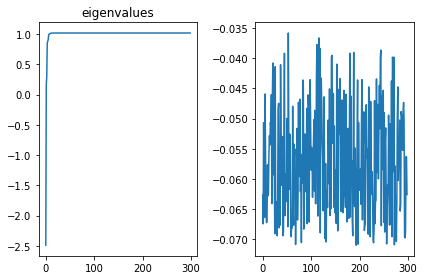

In [11]:
fig = plt.figure()
ax1 = plt.subplot(121)
plt.plot(e)
ax1.title.set_text('eigenvalues')
i = np.where(e < 10e-6)[0]
ax2 = plt.subplot(122)
plt.plot(v[:, i[0]])
fig.tight_layout()
plt.show()

In [19]:
#find optimal number of clusters

def silhouette_coefficient(df):
    '''
    Function to measure silhouette_coefficient 
    Args:
        df : Dataframe  
        
    '''
    range_n_clusters = [2,3,4,5,6,7,8,9,10,11,12,13,14]
    silhouette_avg = []

    for num_clusters in range_n_clusters:
        kmeans = KMeans(n_clusters=num_clusters)
        kmeans.fit(df)
        cluster_labels = kmeans.labels_  
        silhouette_avg.append(silhouette_score(df, cluster_labels))
    

    print(max(silhouette_avg))
    
        
    plt.plot(range_n_clusters,silhouette_avg,'-bx')
    plt.xlabel('Values of K') 
    plt.ylabel('Silhouette score') 
    plt.title('Silhouette analysis For Optimal k')
    plt.show()

0.5946595637035667


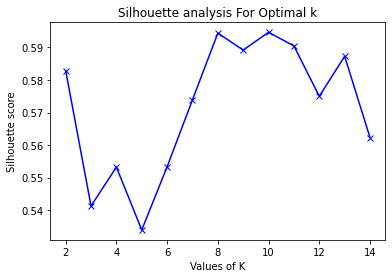

0.41250726678689403


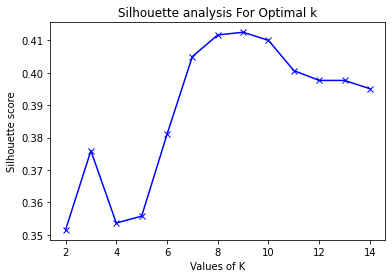

(None, None)

In [20]:
silhouette_coefficient(df_cluster), silhouette_coefficient(df_pca)

In [27]:
def elbowmethod(df):
    '''Function to measure Sum of squared distances 
    Args:
        df : Dataframe
    '''
    Sum_of_squared_distances = []
    K = range(1,10)
    for num_clusters in K :
        kmeans = KMeans(n_clusters=num_clusters)
        kmeans.fit(df)
        Sum_of_squared_distances.append(kmeans.inertia_)
        
    plt.plot(K,Sum_of_squared_distances,'-bx')
    plt.xlabel('Values of K') 
    plt.ylabel('Sum of squared distances') 
    plt.title('Elbow Method For Optimal k')
    plt.show()

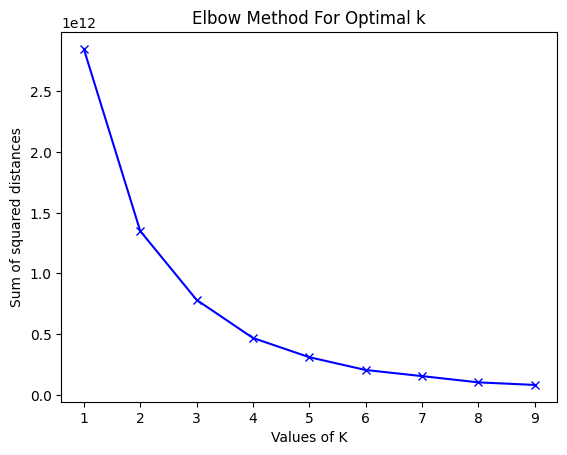

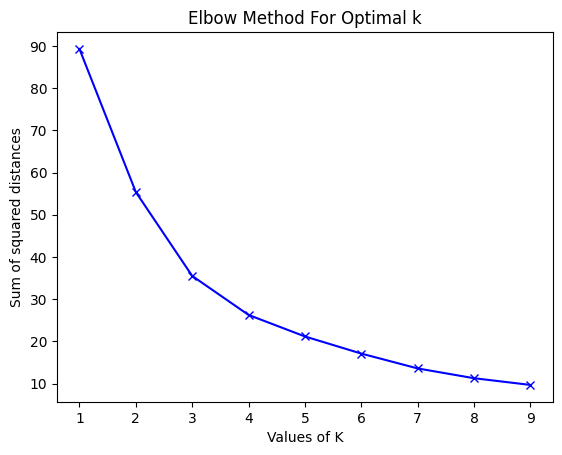

None None


In [31]:
print(elbowmethod(df_cluster), elbowmethod(df_pca))

In [32]:
# Clustering the input data using kmeans 
U = np.array(v[:, i[0]]).reshape(-1, 1)
km = KMeans(init='k-means++', n_clusters=4)
df['clusters'] = km.fit_predict(U)
df

,ID,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT,clusters
0,1,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1,1
1,2,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1,3
2,3,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1,2
3,4,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1,1
4,5,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,295,62.0,0,61,1,38,1,155000.00,1.1,143,1,1,270,0,3
295,296,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0,271,0,3
296,297,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0,278,0,1
297,298,45.0,0,2413,0,38,0,140000.00,1.4,140,1,1,280,0,1
